In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

In [110]:
# Test plotting ellipses
from matplotlib.patches import Ellipse
def plot_ellipse(mu, cov, ax, std=1.0, facecolor='none', edgecolor='red'):
    a = cov[0, 0]
    b = cov[0, 1]
    c = cov[1, 1]
    lam1 = 0.5 * (a + c) + np.sqrt((0.5 * (a - c)) ** 2 + b ** 2)
    lam2 = 0.5 * (a + c) - np.sqrt((0.5 * (a - c)) ** 2 + b ** 2)
    if b == 0.0 and a >= c:
        theta = 0.0
    elif b == 0 and a < c:
        theta = 0.5 * np.pi
    else:
        theta = np.arctan2(lam1 - a, b)
    angle = 0.5 * 360.0 * theta / np.pi
    ell_radius_x = np.sqrt(lam1)
    ell_radius_y = np.sqrt(lam2)
    obj = Ellipse(mu, width=ell_radius_x * std, height=ell_radius_y * std,
                  angle=angle, facecolor=facecolor, edgecolor=edgecolor)
    ax.add_patch(obj)

(-1.0, 1.0)

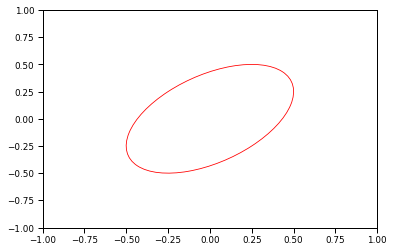

In [105]:
# Test plotting ellipses
cov = np.array([[1.0, 0.5], [0.5, 1.]])
fig, ax = plt.subplots()
plot_ellipse([0, 0], cov, ax)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)

In [93]:
angle = 0.5 * 360.0 * theta / np.pi

29.999999999999996


Rewrite...

Putting everything in the Kalman filter form, we have that:
$$
A =
\begin{bmatrix}
1 & 0 & \Delta t & 0\\
0 & 1 & 0 & \Delta t\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix},
$$
the control matrix is:
$$
B = \begin{bmatrix}
0 & 0\\
0 & 0\\
\frac{\Delta t}{m} & 0\\
0 & \frac{\Delta t}{m}
\end{bmatrix}
$$
$$
$$
and the process covariance is:
$$
Q = \begin{bmatrix}
\epsilon & 0 & 0 & 0\\
0 & \epsilon & 0 & 0\\
0 & 0 & \sigma^2_q & 0\\
0 & 0 & 0 & \sigma^2_q
\end{bmatrix},
$$
where we have included a small $\epsilon>0$ in the first term of the diagonal to avoid making $Q$ rank-defficient.

What about the measurements.
Let's assume that we measure a noisy version of the position of the object, i.e.,
$$
y_n = Cx_n + w_n,
$$
with
$$
C = \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
$$
with measurement covariance:
$$
R =
\begin{bmatrix}
\sigma_r^2 & 0 \\
0 & \sigma_r^2
\end{bmatrix}
$$

In [270]:
# Let's now take a sample trajectory of such a particle
Dt = 1.0
m = 1.0
epsilon = 1e-6
sigma_q = 1e-2
sigma_r = 0.5
# Initial conditions
mu0 = np.zeros((4,))
P0 = np.array([1.0, 1.0, 1.0, 1.0]) * np.eye(4)
A = np.array([[1.0, 0, Dt, 0],
              [0.0, 1.0, 0.0, Dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
B = np.array([[0.0, 0.0],
              [0.0, 0.0],
              [Dt / m, 0.0],
              [0.0, Dt / m]])
Q = np.array([epsilon, epsilon, sigma_q ** 2, sigma_q ** 2]) * np.eye(4)
C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])
R = np.array([sigma_r ** 2, sigma_r ** 2]) * np.eye(2)

In [285]:
num_steps = 50
true_trajectory = np.ndarray((num_steps + 1, 4))
observations = np.ndarray((num_steps, 2))
#x0 = mu0 + np.sqrt([1.0, 1.0, 0.01, 0.01]) * np.random.randn(4)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
true_trajectory[0] = x0
force = .1
omega = 2.0 * np.pi / 5
times = Dt * np.arange(num_steps + 1)
us = np.zeros((num_steps, 2))
us[:, 0] = force * np.cos(omega * times[1:])
us[:, 1] = force * np.sin(omega * times[1:])
#us = np.random.randn(num_steps, 2)

for n in range(num_steps):
    x = np.dot(A, true_trajectory[n]) + np.dot(B, us[n]) + np.sqrt(np.diag(Q)) * np.random.randn(4)
    true_trajectory[n+1] = x
    y = np.dot(C, x) + np.sqrt(np.diag(R)) * np.random.randn(2)
    observations[n] = y

In [286]:
help(writer.saving)

Help on method saving in module matplotlib.animation:

saving(fig, outfile, dpi, *args, **kwargs) method of matplotlib.animation.FFMpegWriter instance
    Context manager to facilitate writing the movie file.
    
    ``*args, **kw`` are any parameters that should be passed to `setup`.



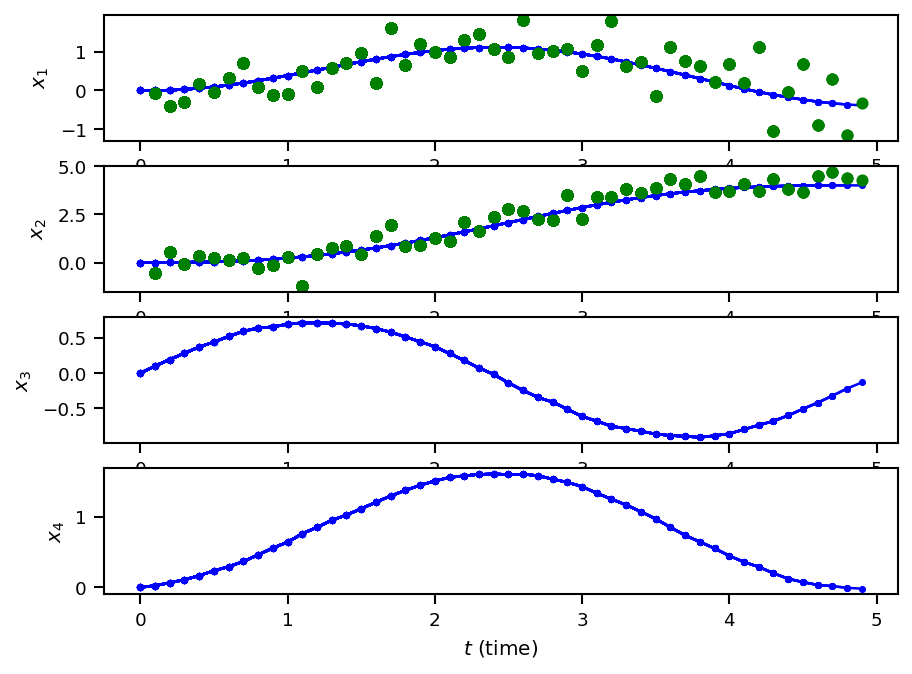

In [287]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Raw results from linear system', artist='Matplotlib',
                comment='Raw results from linear system')
writer = FFMpegWriter(fps=1, metadata=metadata, bitrate=8000)

y_labels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$']

res_x = 1024
res_y = 768
dpi = 150
w_in = res_x / dpi
h_in = res_y / dpi
fig, ax = plt.subplots(4, 1, dpi=dpi)
fig.set_size_inches(w_in, h_in)

    
for j in range(4):
    ax[j].set_ylabel(y_labels[j])
ax[-1].set_xlabel('$t$ (time)')

with writer.saving(fig, 'raw_linear_system.mp4', dpi):
    for n in range(1, num_steps):
        for j in range(4):
            ax[j].plot(times[:n+1], true_trajectory[:n+1, j], 'b.-')
            if j < 2:
                ax[j].plot(times[1:n+1], observations[:n, j], 'go')
        writer.grab_frame()

In [254]:
from filterpy.kalman import KalmanFilter

In [293]:
kf = KalmanFilter(dim_x=4, dim_z=2)

/Users/ibilion/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/Users/ibilion/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/Users/ibilion/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly

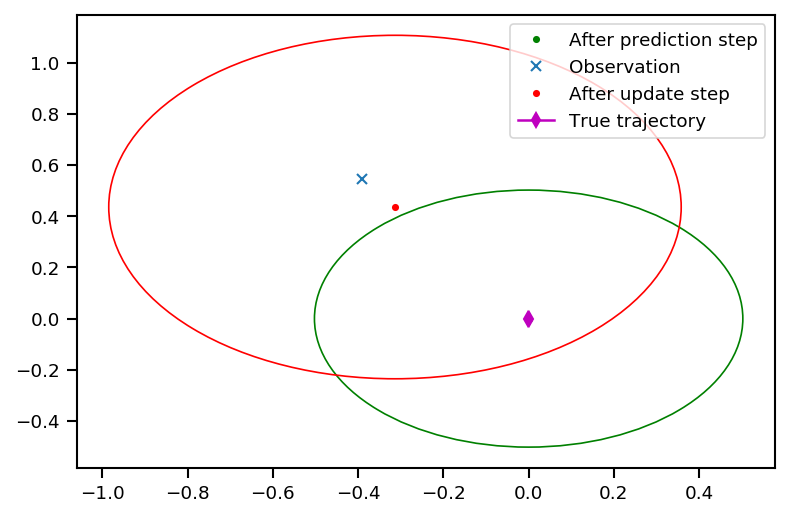

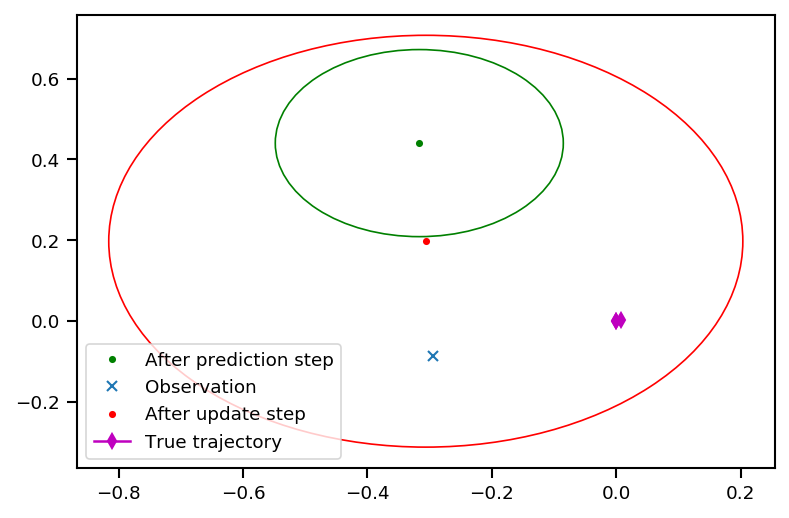

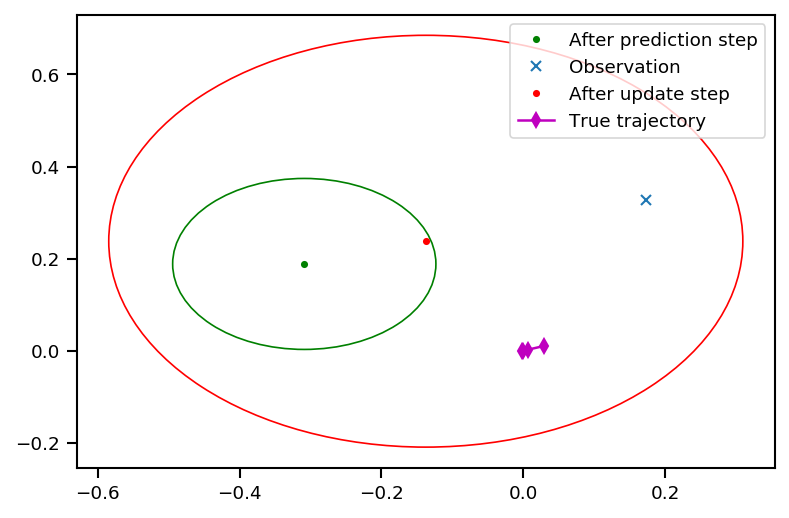

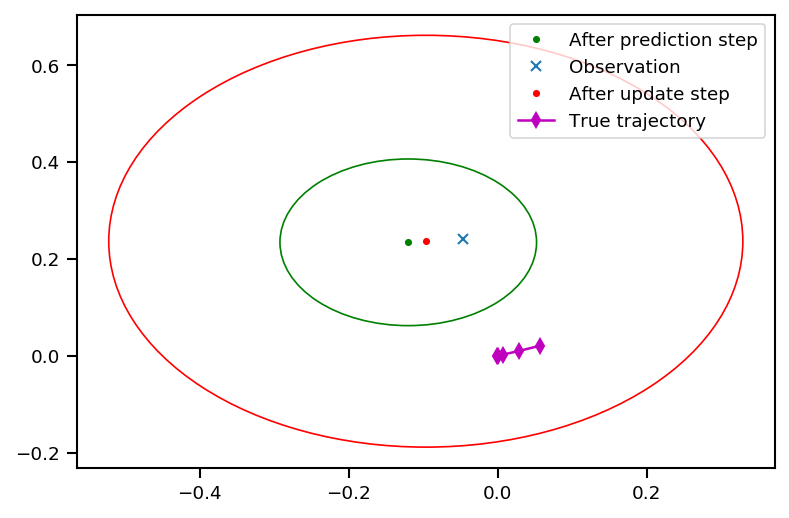

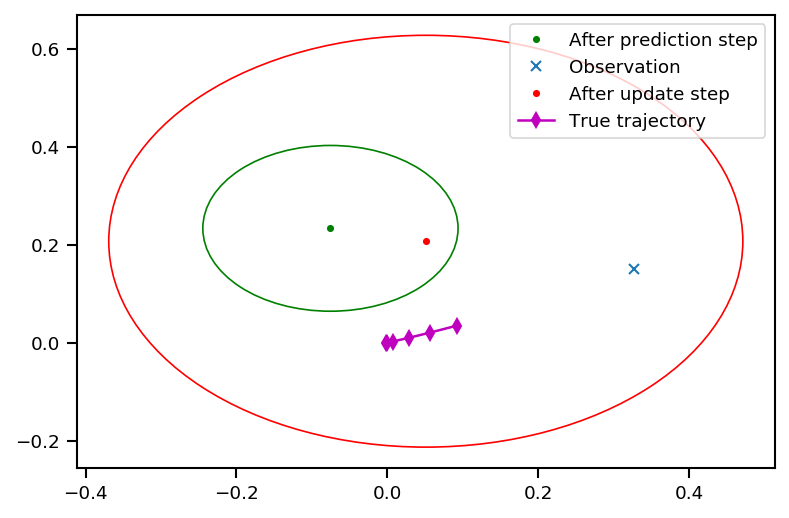

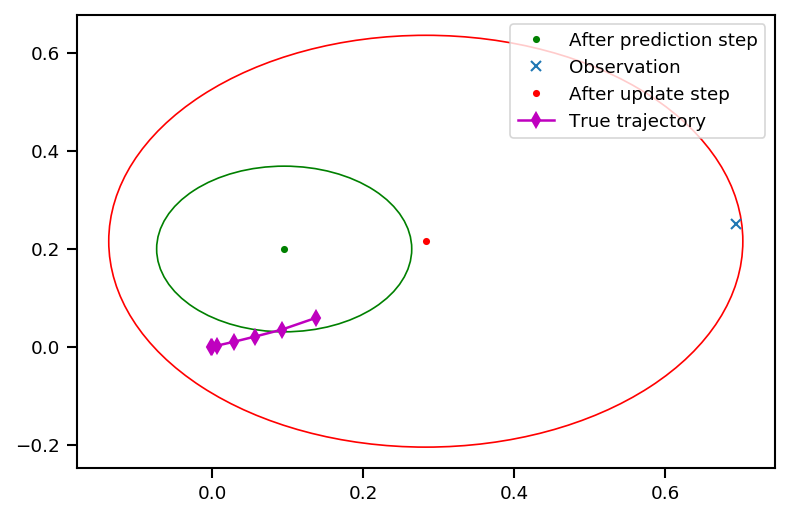

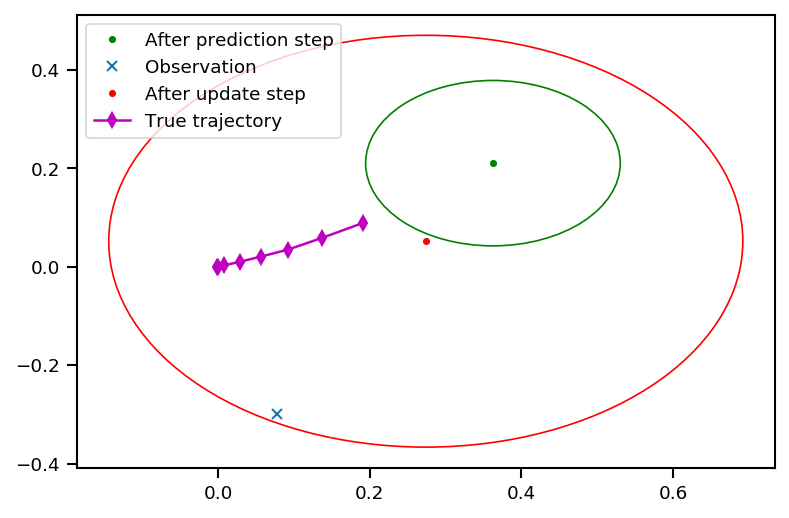

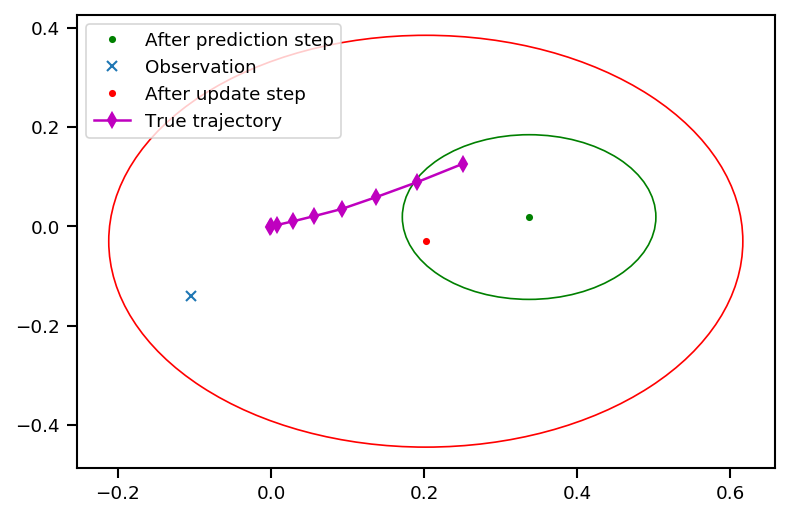

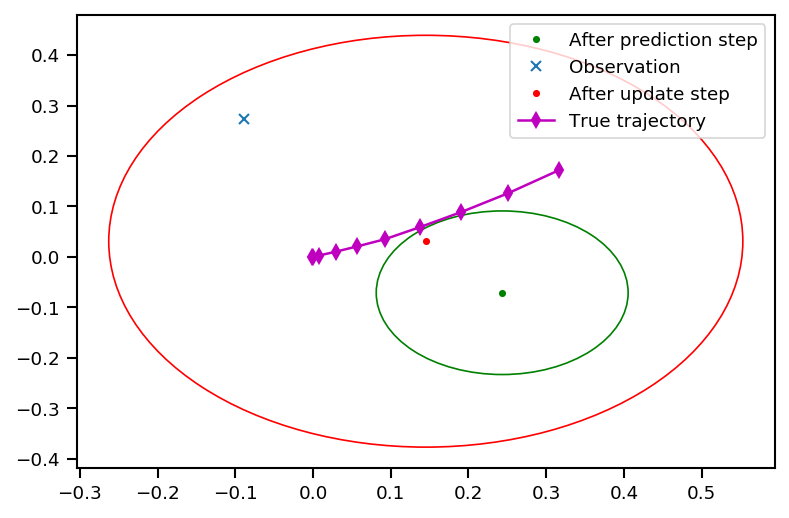

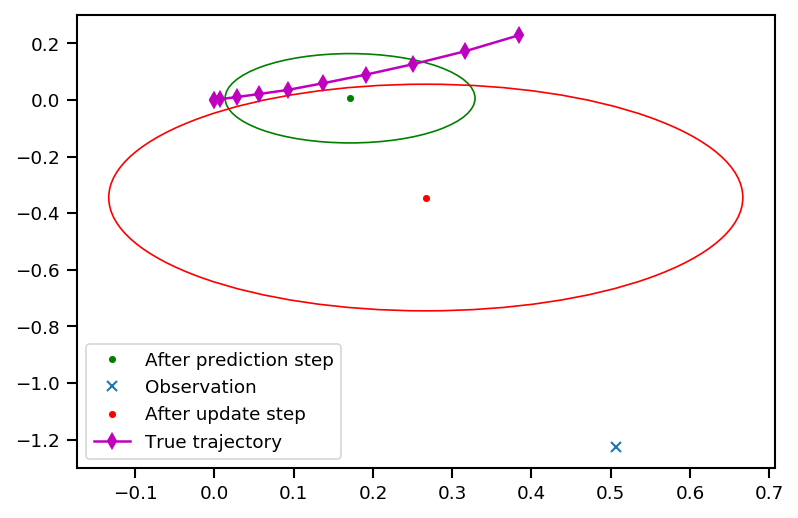

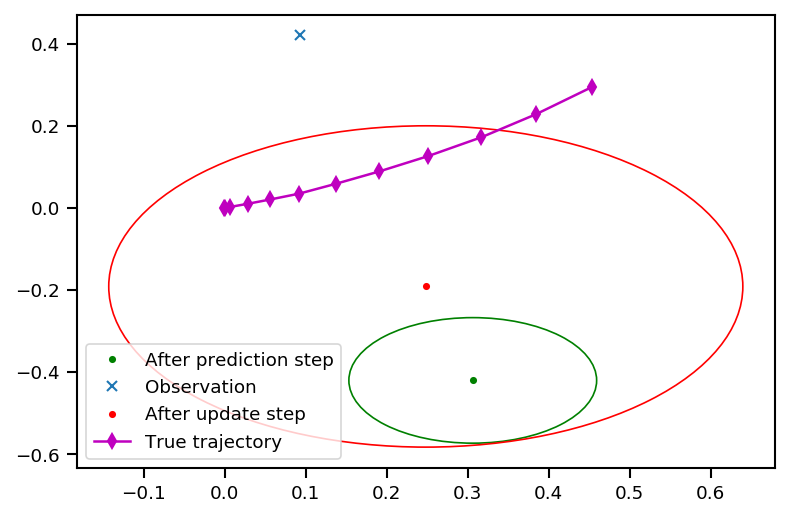

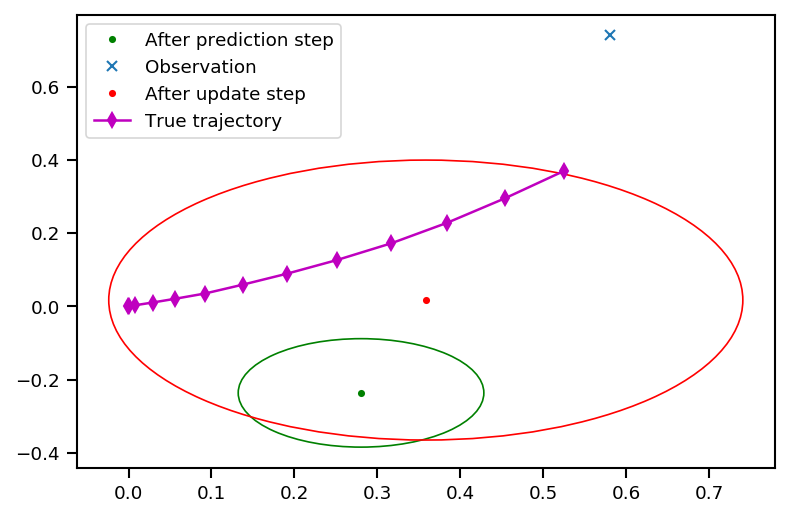

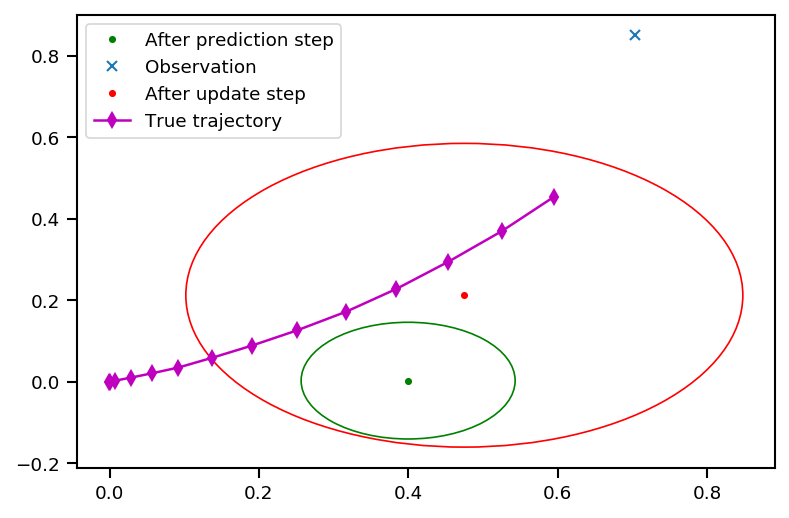

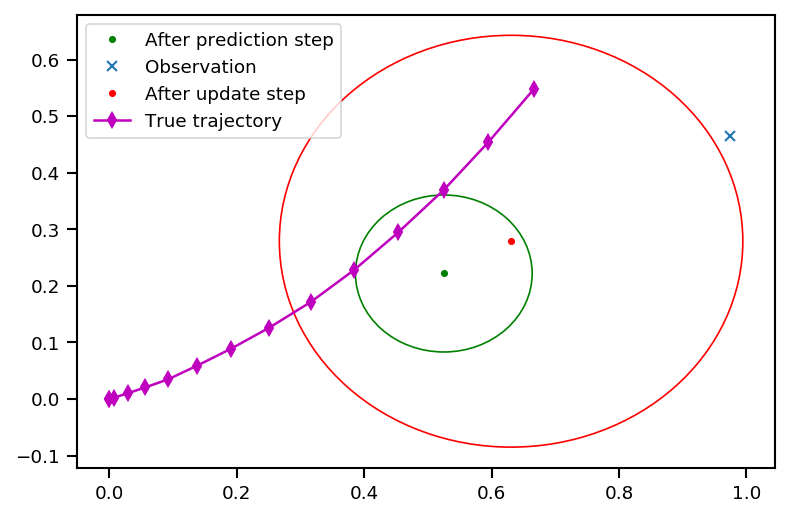

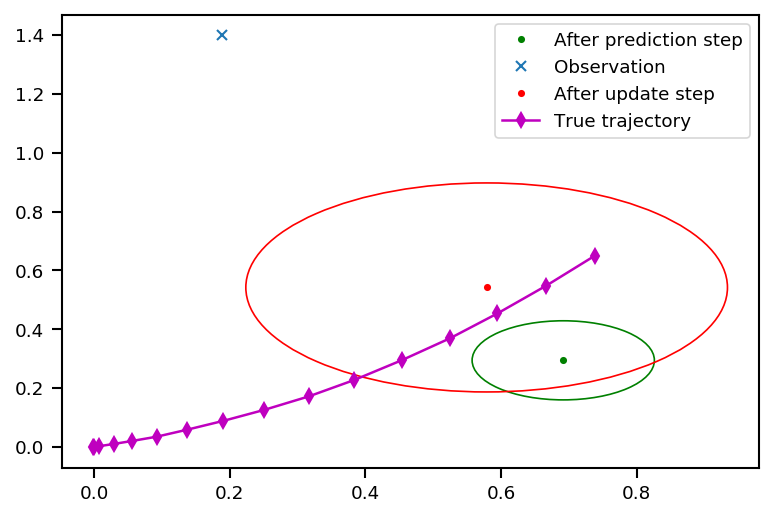

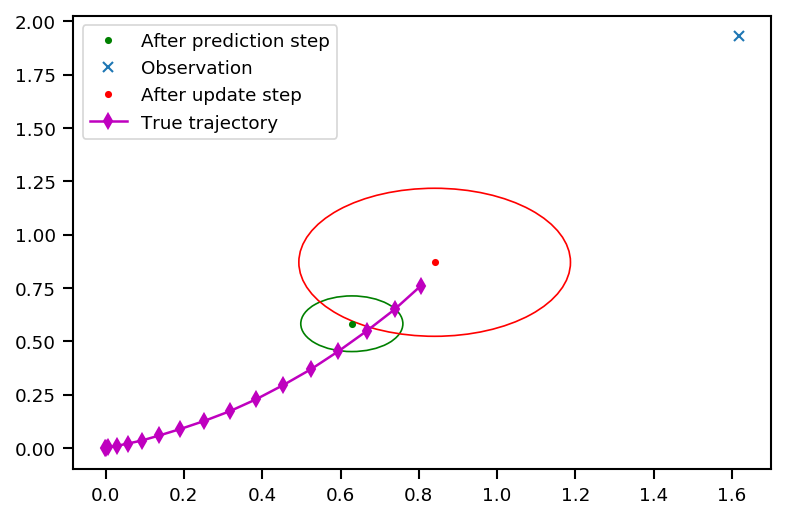

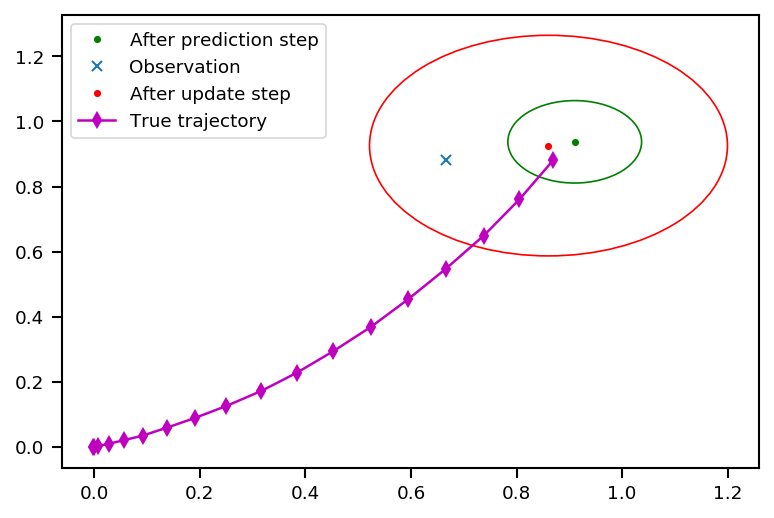

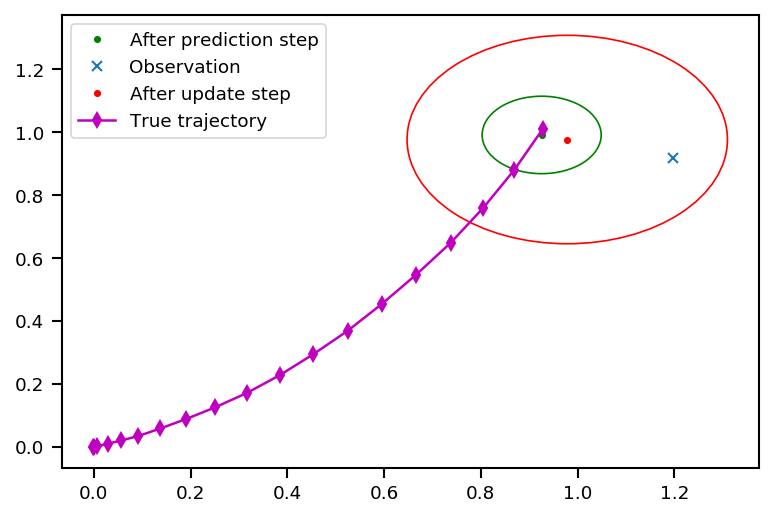

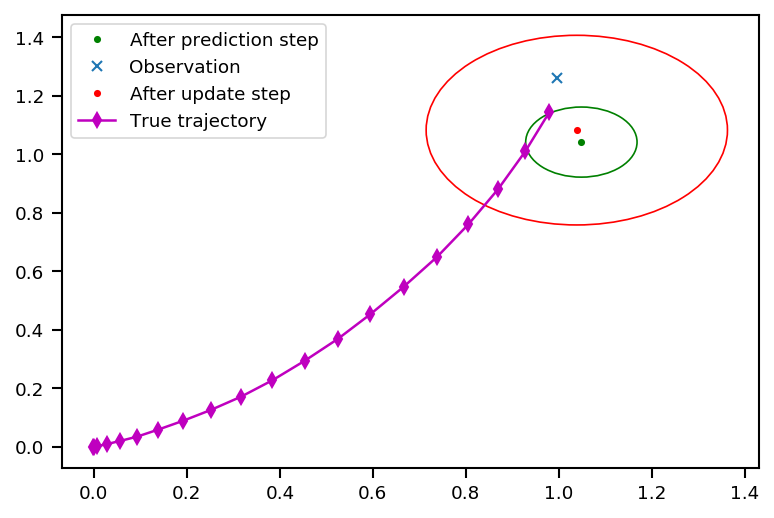

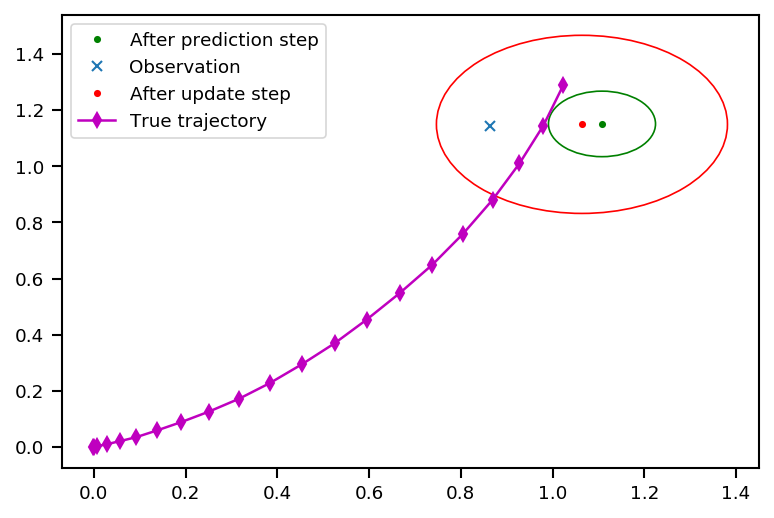

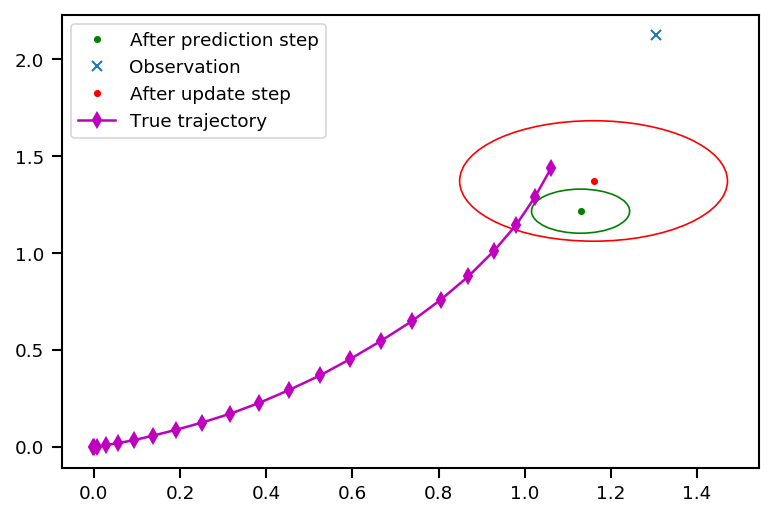

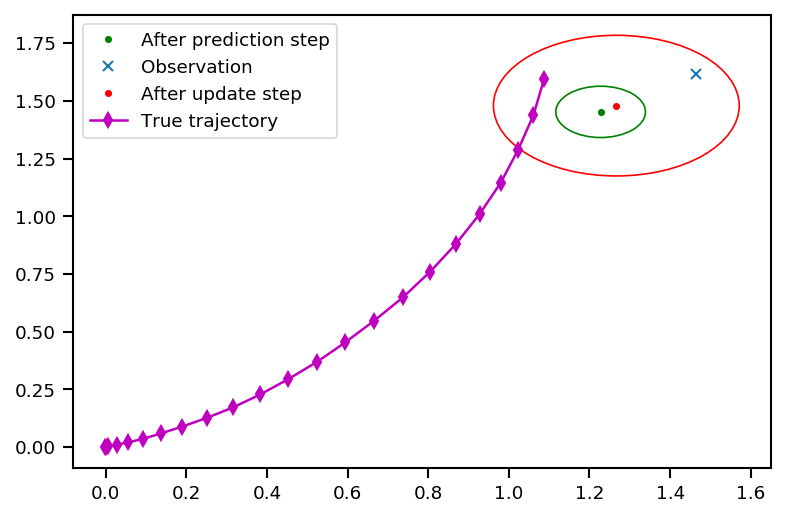

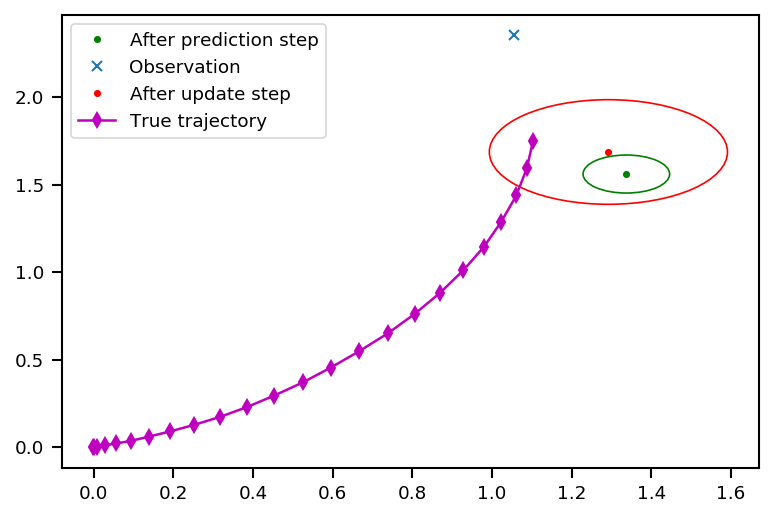

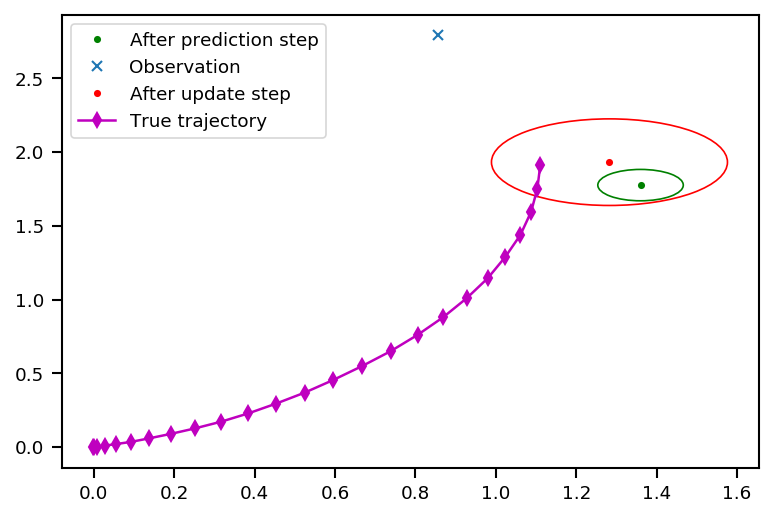

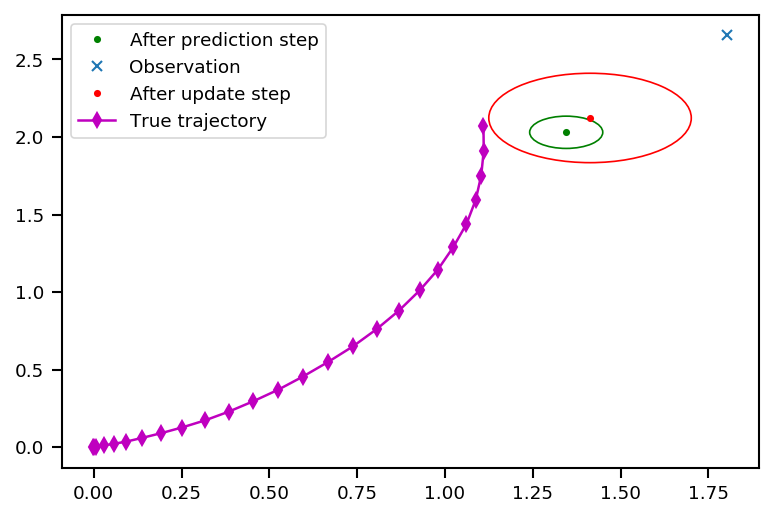

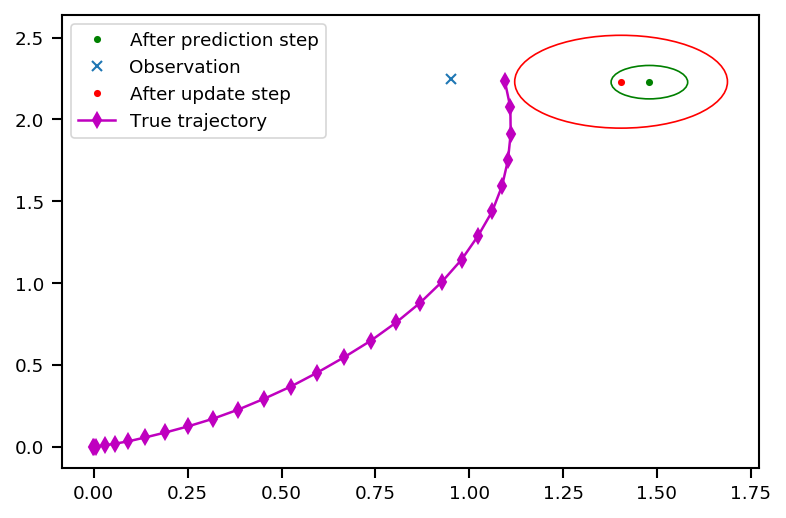

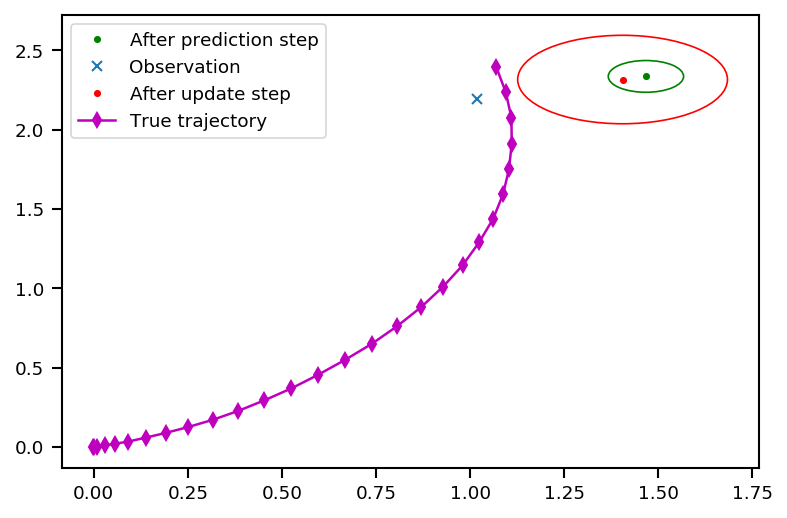

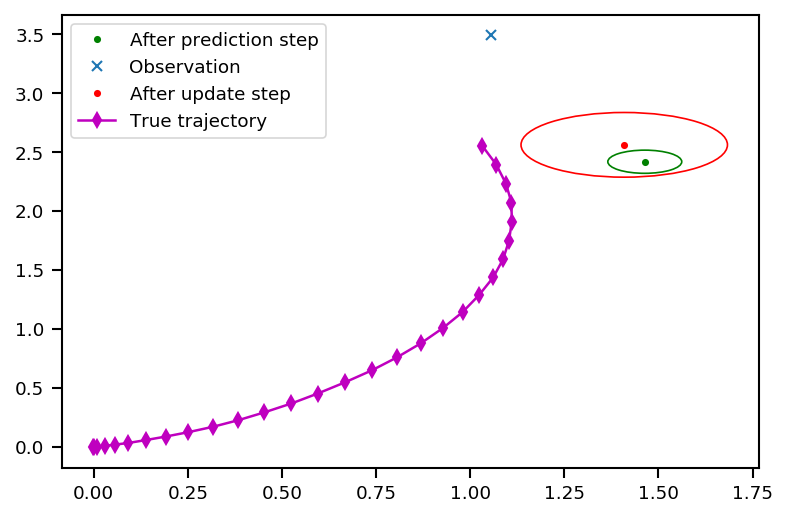

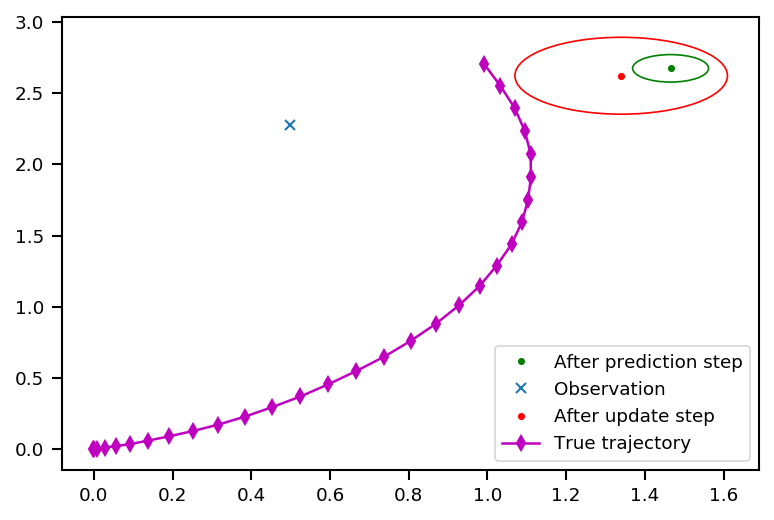

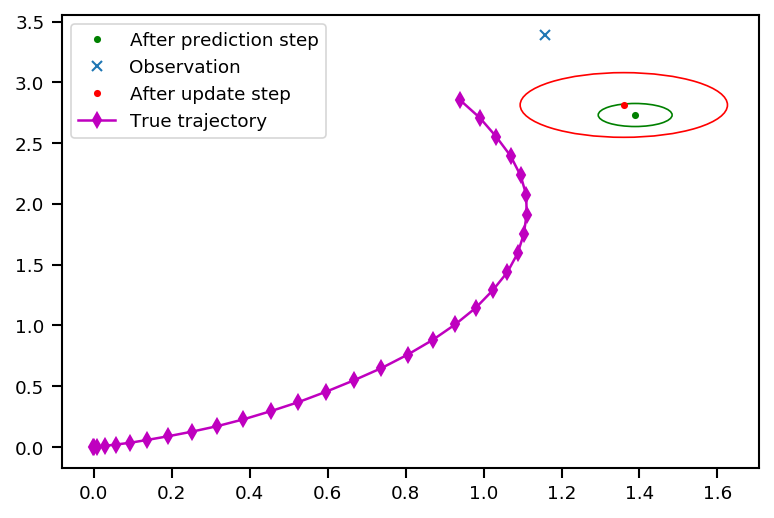

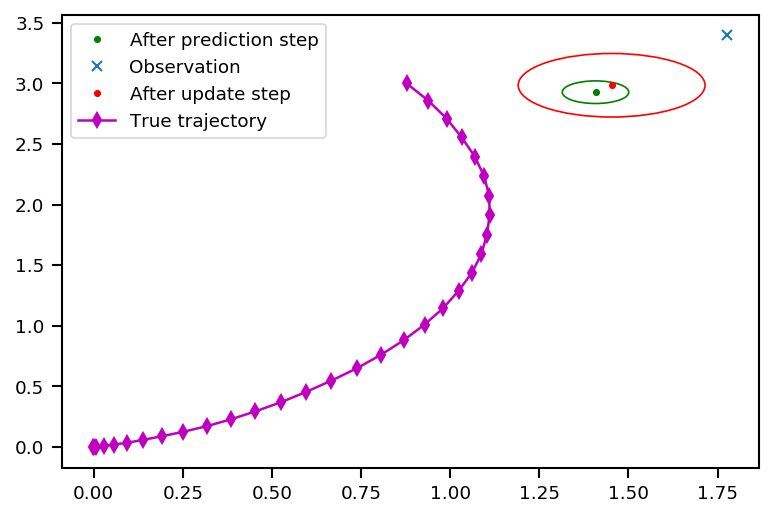

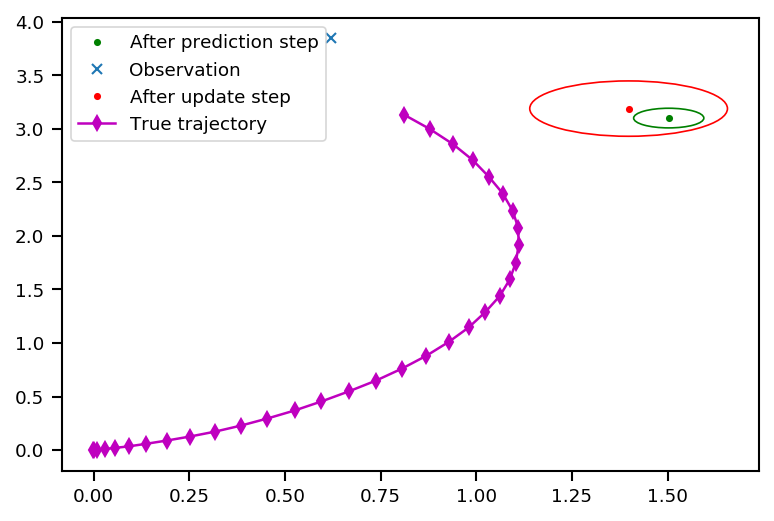

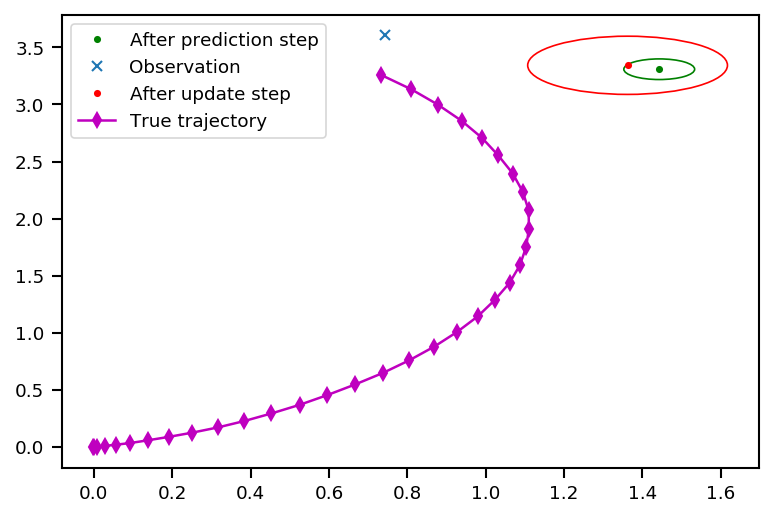

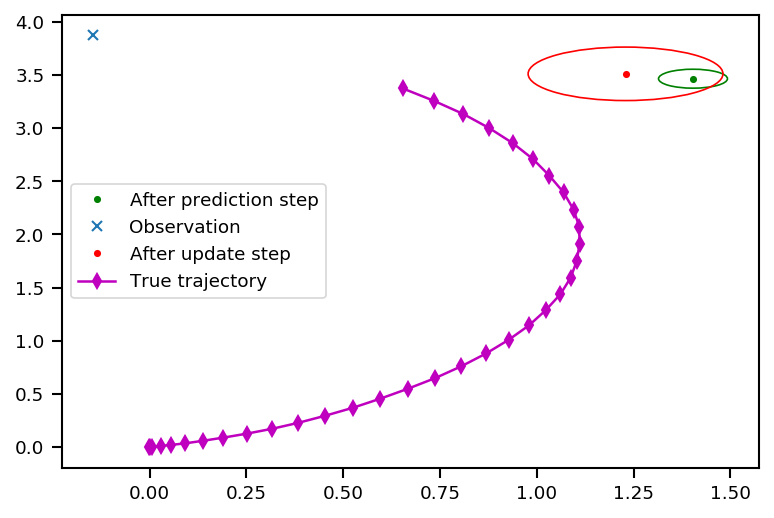

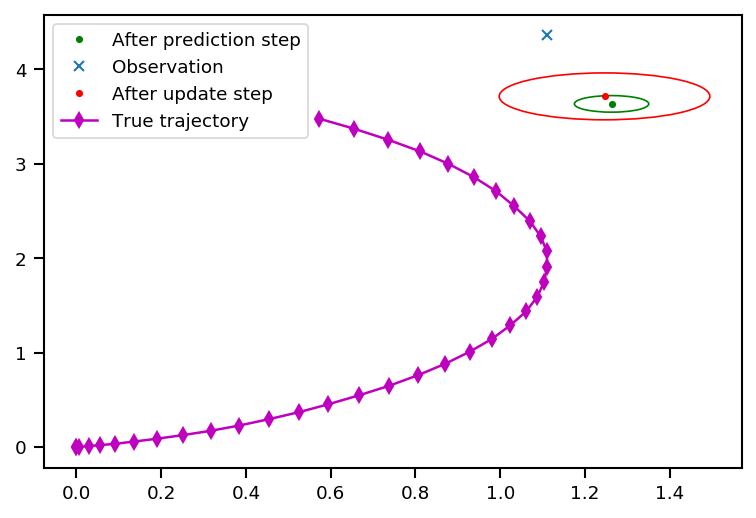

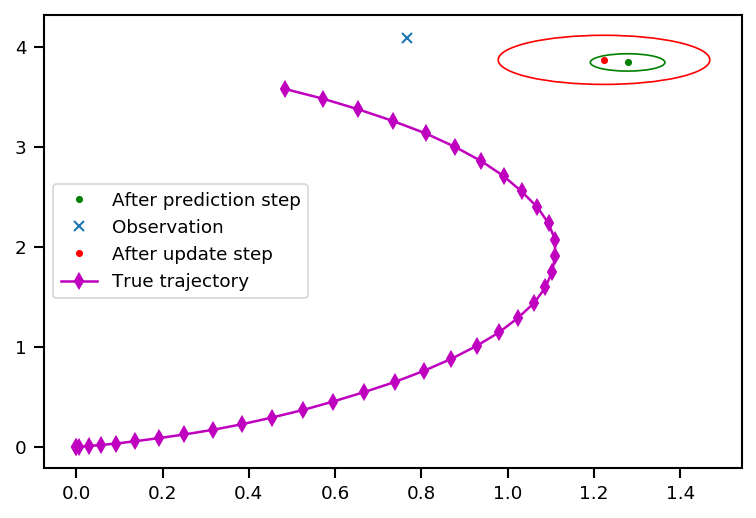

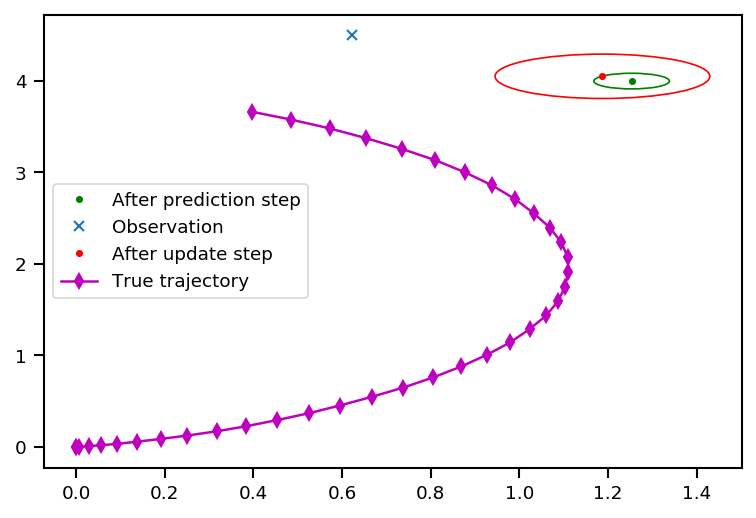

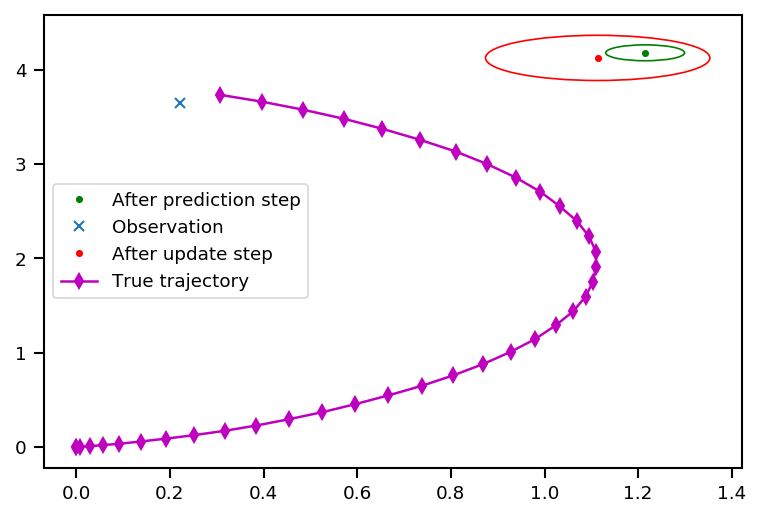

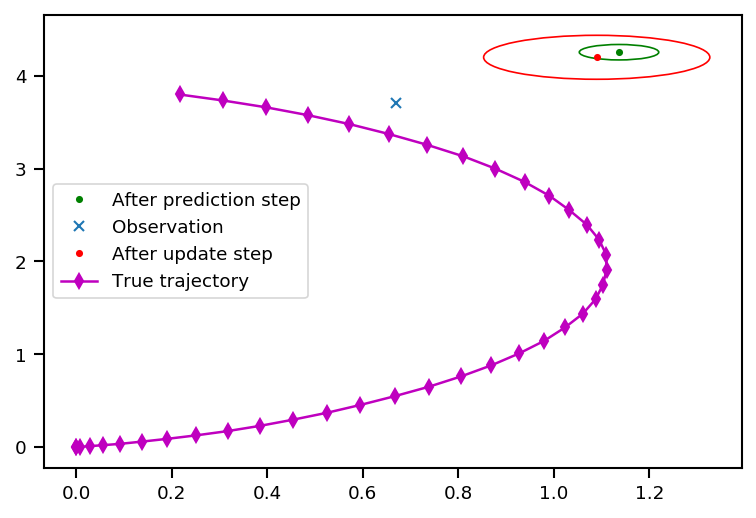

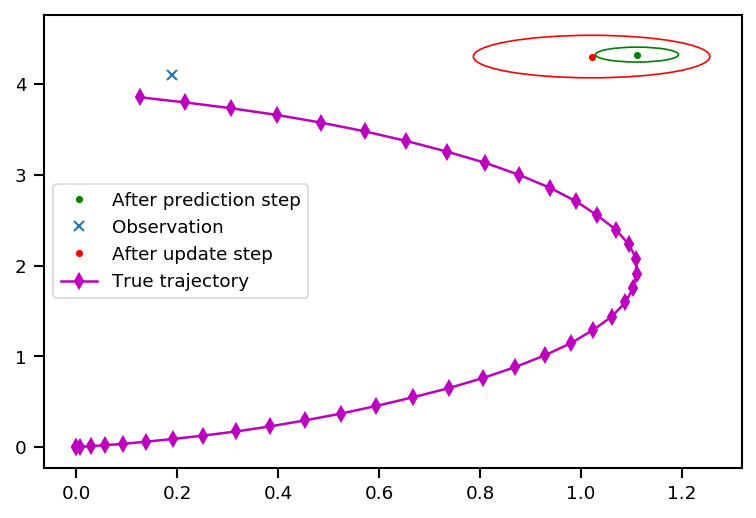

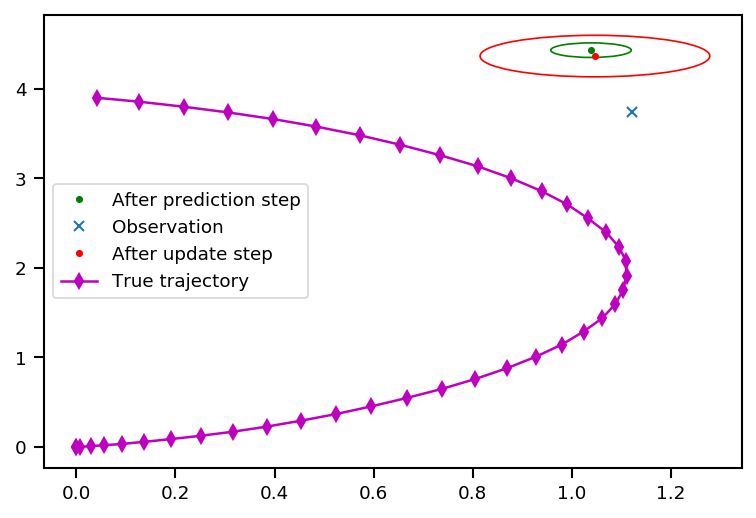

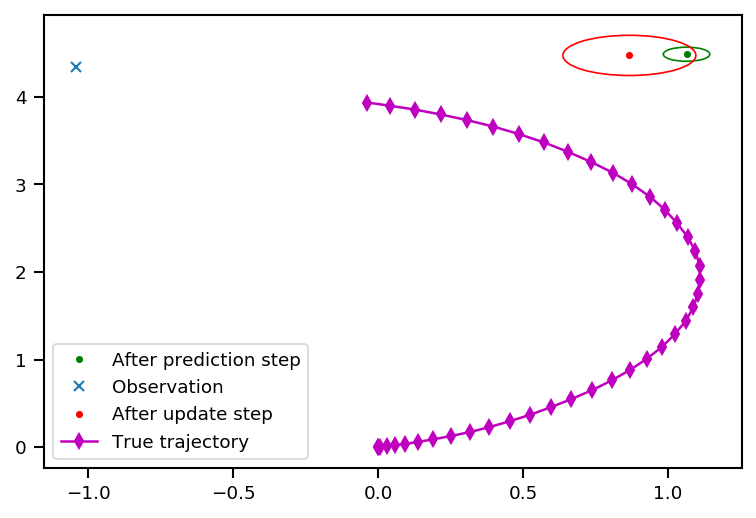

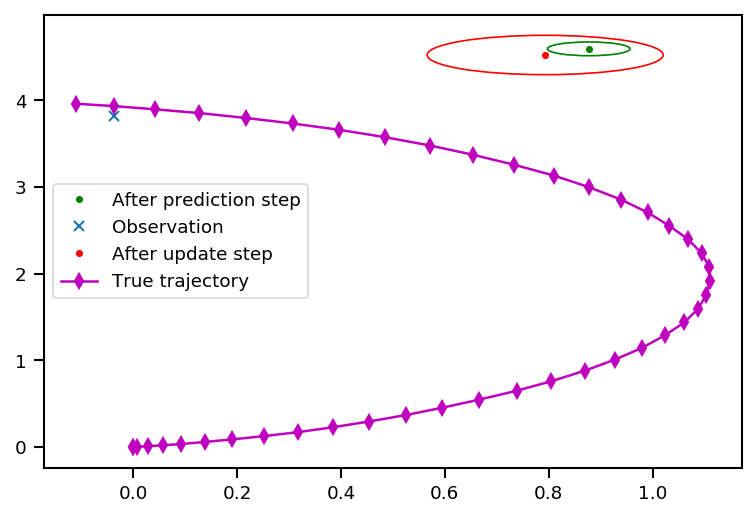

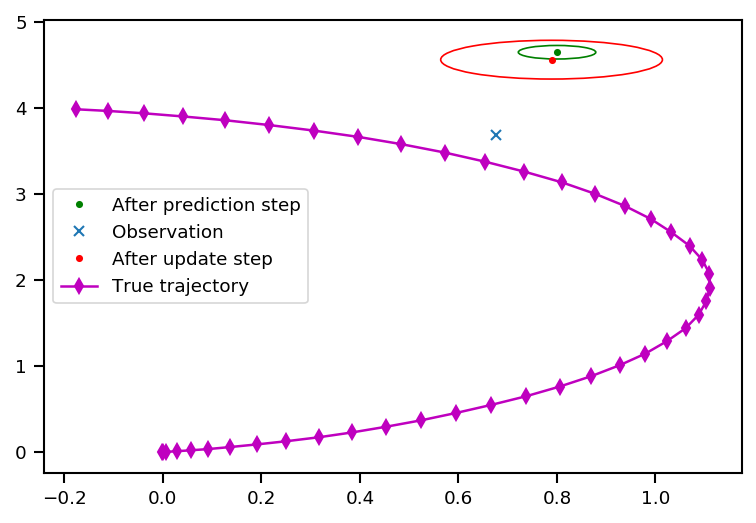

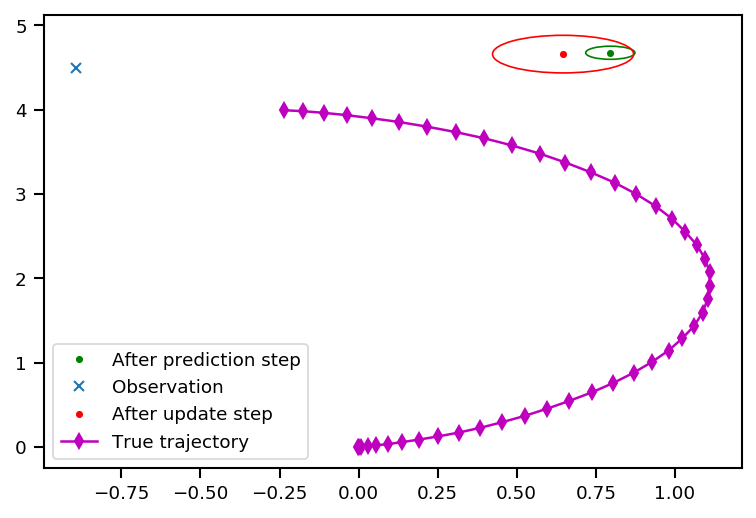

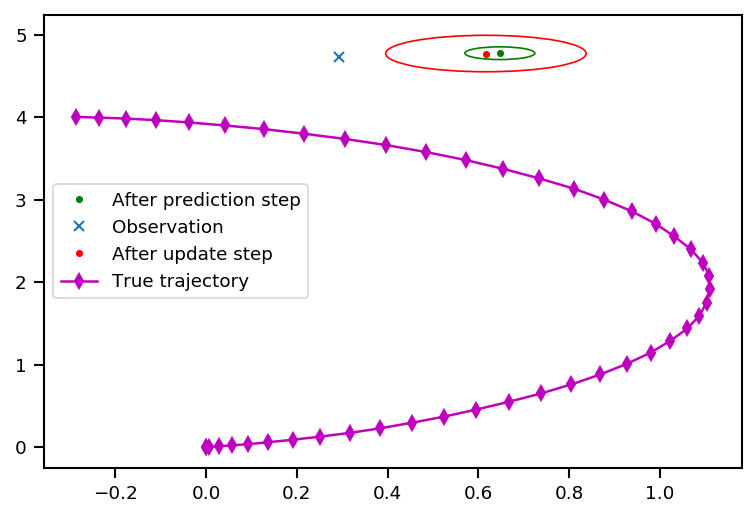

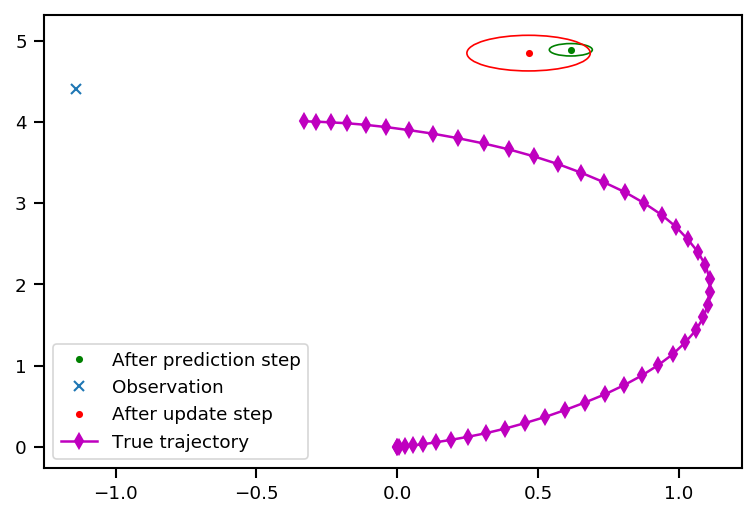

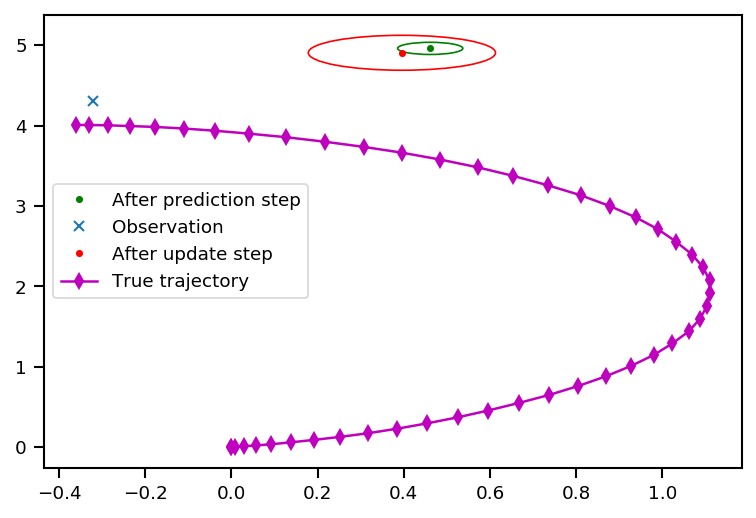

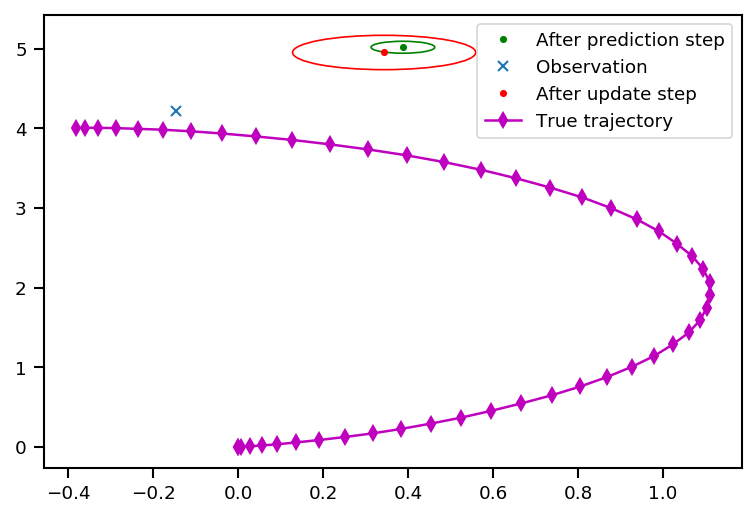

In [297]:
kf.x = mu0
kf.P = P0
kf.Q = Q
kf.R = R
kf.H = C
kf.F = A
kf.B = B
for n in range(1, num_steps):
    fig, ax = plt.subplots(dpi=150)
    #ax.plot(true_trajectory[:i+2, 0], true_trajectory[:i+2, 1], 'b-o', markersize=1, markeredgewidth=1)
    # Predict step
    kf.predict()
    ax.plot(kf.x[0], kf.x[1], 'g.', label='After prediction step')
    plot_ellipse(kf.x[:2], kf.P[:2, :2], ax, edgecolor='green')
    #plot_ellipse(kf.x[:2], P0, ax, edgecolor='green')
    # Update step
    ax.plot(observations[n,0], observations[n,1], 'x', label='Observation')
    kf.update(observations[n])
    #print(kf.x)
    ax.plot(kf.x[0], kf.x[1], 'r.', label='After update step')
    plot_ellipse(kf.x[:2], kf.P[:2, :2], ax, std=3.0, edgecolor='red')
    ax.plot(true_trajectory[:n+1, 0], true_trajectory[:n+1, 1], 'md-', label='True trajectory')
    #ax.set_xlim(-2.0, 2.0)
    #ax.set_ylim(-2.0, 2.0)
    plt.legend(loc='best')

In [298]:
kf.x = mu0
kf.P = P0
kf.Q = Q
kf.R = R
kf.H = C
kf.F = A
kf.B = B
res = kf.batch_filter(observations, us=us)

In [299]:
means = res[0]
covs = res[1]

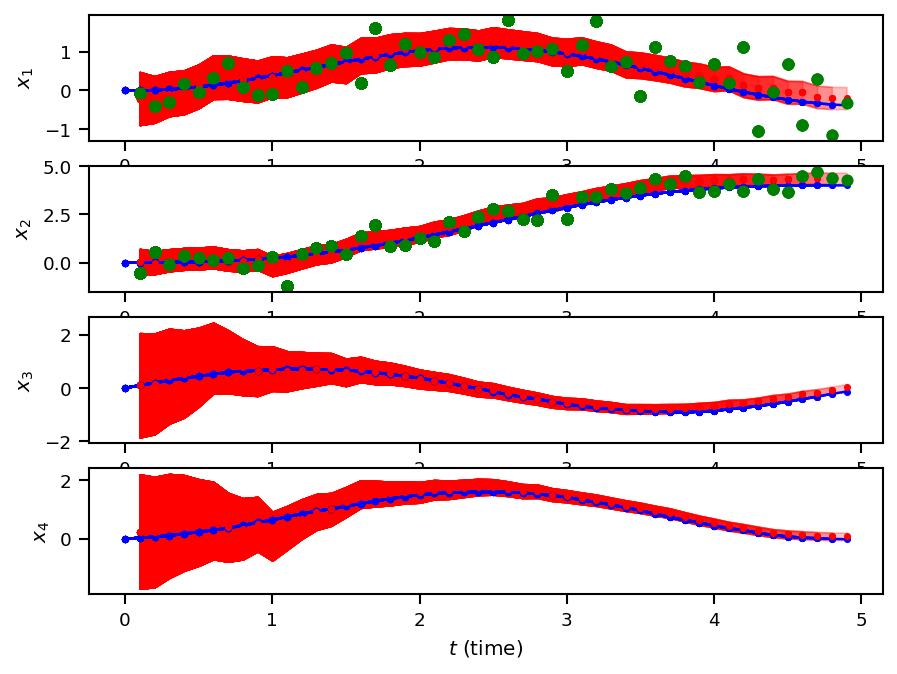

In [300]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Raw results from linear system', artist='Matplotlib',
                comment='Raw results from linear system')
writer = FFMpegWriter(fps=1, metadata=metadata, bitrate=8000)

y_labels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$']

res_x = 1024
res_y = 768
dpi = 150
w_in = res_x / dpi
h_in = res_y / dpi
fig, ax = plt.subplots(4, 1, dpi=dpi)
fig.set_size_inches(w_in, h_in)

times = Dt * np.arange(num_steps + 1)
    
for j in range(4):
    ax[j].set_ylabel(y_labels[j])
ax[-1].set_xlabel('$t$ (time)')

with writer.saving(fig, 'kf_linear_system.mp4', dpi):
    for n in range(1, num_steps):
        for j in range(4):
            ax[j].plot(times[:n+1], true_trajectory[:n+1, j], 'b.-')
            ax[j].plot(times[1:n+1], means[1:n+1, j], 'r.')
            ax[j].fill_between(times[1:n+1],
                               means[1:n+1, j] - 2.0 * np.sqrt(covs[1:n+1, j, j]),
                               means[1:n+1, j] + 2.0 * np.sqrt(covs[1:n+1, j, j]),
                               color='red', alpha=0.25)
                                
            if j < 2:
                ax[j].plot(times[1:n+1], observations[:n, j], 'go')
        writer.grab_frame()

In [246]:
help(kf.rts_smoother)

Help on method rts_smoother in module filterpy.kalman.kalman_filter:

rts_smoother(Xs, Ps, Fs=None, Qs=None, inv=<function inv at 0x1102c2c20>) method of filterpy.kalman.kalman_filter.KalmanFilter instance
    Runs the Rauch-Tung-Striebal Kalman smoother on a set of
    means and covariances computed by a Kalman filter. The usual input
    would come from the output of `KalmanFilter.batch_filter()`.
    
    Parameters
    ----------
    
    Xs : numpy.array
       array of the means (state variable x) of the output of a Kalman
       filter.
    
    Ps : numpy.array
        array of the covariances of the output of a kalman filter.
    
    Fs : list-like collection of numpy.array, optional
        State transition matrix of the Kalman filter at each time step.
        Optional, if not provided the filter's self.F will be used
    
    Qs : list-like collection of numpy.array, optional
        Process noise of the Kalman filter at each time step. Optional,
        if not provided th

In [147]:
x, P, _, _ = kf.rts_smoother(means, covs)

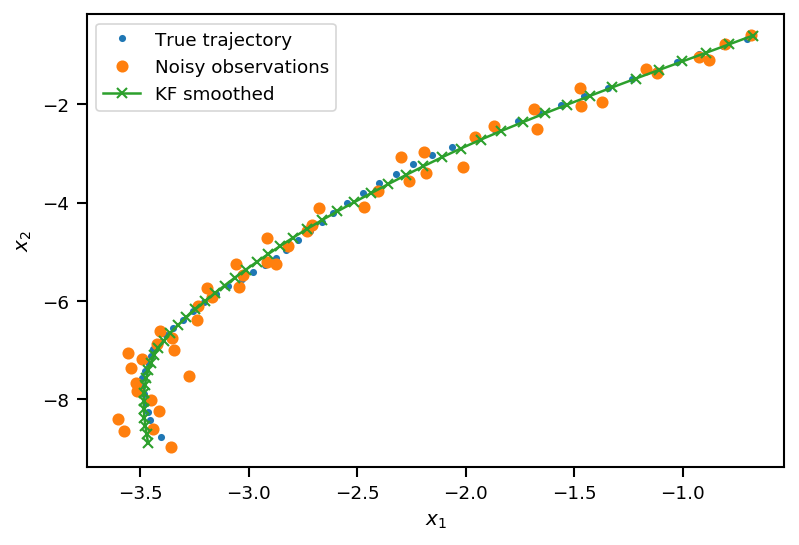

In [150]:
fig, ax = plt.subplots(dpi=150)
ax.plot(true_trajectory[1:, 0], true_trajectory[1:, 1], '.', label='True trajectory')
ax.plot(observations[:, 0], observations[:, 1], 'o', label='Noisy observations')
ax.plot(x[:, 0], x[:, 1], '-x', label='KF smoothed')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.legend(loc='best')

In [362]:
means

array([[-1.11700634e+00,  3.97690996e-01,  0.00000000e+00,
         0.00000000e+00],
       [-1.23200829e+00,  4.65563295e-01, -1.14715766e-01,
         6.77033946e-02],
       [-1.22781653e+00,  6.51731008e-01, -4.30527060e-02,
         1.39099340e-01],
       [-1.20693442e+00,  8.14239968e-01, -1.49037764e-02,
         1.49406021e-01],
       [-1.23404960e+00,  9.60495257e-01, -1.93082528e-02,
         1.48269597e-01],
       [-1.30505178e+00,  1.10362332e+00, -3.59648427e-02,
         1.46612914e-01],
       [-1.37592407e+00,  1.25332842e+00, -4.66697916e-02,
         1.47561186e-01],
       [-1.42325882e+00,  1.39116782e+00, -4.68713121e-02,
         1.44614929e-01],
       [-1.44378046e+00,  1.54870477e+00, -3.88546808e-02,
         1.48546325e-01],
       [-1.44542801e+00,  1.66170511e+00, -2.74587077e-02,
         1.37659137e-01],
       [-1.53889183e+00,  1.80177706e+00, -4.77686755e-02,
         1.38401566e-01],
       [-1.56938546e+00,  1.93305113e+00, -4.24420760e-02,
      

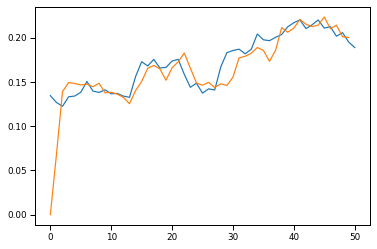

In [371]:
plt.plot(true_trajectory[:, 3])
plt.plot(means[:, 3])

In [375]:
covariances[:, 3, 3]

array([1.00000000e+00, 5.06994189e-03, 1.37229926e-03, 6.56588981e-04,
       4.39531052e-04, 3.62903053e-04, 3.35843702e-04, 3.27473566e-04,
       3.25621269e-04, 3.25475194e-04, 3.25441982e-04, 3.25234198e-04,
       3.24949486e-04, 3.24702532e-04, 3.24538283e-04, 3.24449528e-04,
       3.24410366e-04, 3.24396845e-04, 3.24393680e-04, 3.24393414e-04,
       3.24393364e-04, 3.24393024e-04, 3.24392551e-04, 3.24392136e-04,
       3.24391858e-04, 3.24391708e-04, 3.24391641e-04, 3.24391617e-04,
       3.24391612e-04, 3.24391611e-04, 3.24391611e-04, 3.24391611e-04,
       3.24391610e-04, 3.24391609e-04, 3.24391609e-04, 3.24391609e-04,
       3.24391608e-04, 3.24391608e-04, 3.24391608e-04, 3.24391608e-04,
       3.24391608e-04, 3.24391608e-04, 3.24391608e-04, 3.24391608e-04,
       3.24391608e-04, 3.24391608e-04, 3.24391608e-04, 3.24391608e-04,
       3.24391608e-04, 3.24391608e-04])

(-1.0, 1.0)

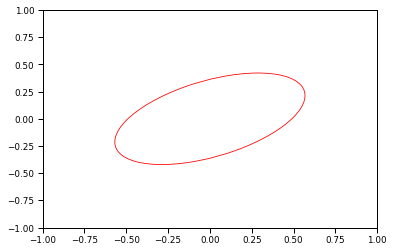

In [39]:
# Test plotting ellipses
from matplotlib.patches import Ellipse
cov = np.array([[1.0, 0.8], [0.8, 2.]])
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
obj = Ellipse([0.0, 0.0], width=ell_radius_x, height=ell_radius_y,
              angle=np.arctan(pearson) / (2.0 * np.pi) * 360.0,
              facecolor='none', edgecolor='red')
fig, ax = plt.subplots()
ax.add_patch(obj)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)